# 사전학습 여부에 따른 BERT 모델 성능 개선 여부 확인 예제
## : KorQuA를 중심으로

#### 초록
***
<span style="font-size:11pt; line-height:1.8;">
    &nbsp; &nbsp; KorQuA를 이용하여 사전학습된 BERT 모델과 사전학습이 되지 않은 BERT 모델의 성능을 비교한다. KorQuA 문제와 BERT를 중심으로 설명한 후, 사전학습된 BERT 모델과 사전학습이 되지 않은 BERT 모델을 생성하여 그 성능을 비교하였다. 두 모델 모두 6개의 인코더 레이어와 8개의 멀티 헤드를 사용하고 학습 횟수는 5회로 설정하였다. 학습결과, 사전학습 되지 않은 모델의 경우 검증 데이터에 대한 정확도가 감소하는 추세를 보였으며, 최종적으로 약 0.003에 해당하였다. 사전학습 된 모델의 경우 검증 데이터에 대한 정확도가 증가하는 추세를 보였으며, 최종적으로 약 0.5에 해당하였다. 나아가 검증 데이터 10개를 사전학습된 모델에 입력하여 확인한 결과, 여러 분제에 대해 올바르게 예측하였다.
</span>

***

<br>

## 1. 서론
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 본 예제에서는 KorQuA를 이용하여 사전학습된 BERT 모델과 사전학습이 되지 않은 BERT 모델의 성능을 비교하고자 합니다. 특히, KorQuA 문제가 무엇인지 그리고 BERT의 작동 방식을 중심으로 설명하고자 합니다. 다음은 본 예제의 진행 순서를 제시한 것입니다.
</span><br><br>


> _1. KorQuA 문제에 대한 설명_
>
> _2. BERT에 대한 설명_
>
> _3. 데이터 정제_
>
> _4. 데이터 분석_
>
> _5. 데이터 전처리_
>
> _6. 모델 생성 및 학습_


***

#### 필요 라이브러리 호출
***
+ 예제에 사용되는 라이브러리를 호출 합니다.
***

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

import seaborn as sns   #시각화
from wordcloud import WordCloud   #워드 클라우드

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import sentencepiece as spm   #SentencePiece 모델

import tensorflow as tf   #계산 그래프
import tensorflow.keras.backend as K   #케라스
import tensorflow_addons as tfa

import os   #디렉토리 관리
import re   #정규식
import json   #Json 처리
import random   #난수
import pickle   #피클 파일
import numpy as np   #행렬 연산
import collections   #데이터 처리
import pandas as pd   #데이터프레임
from datetime import datetime   #시간

from tqdm.notebook import tqdm

random.seed(1234)   #시드 설정
np.random.seed(1234)
tf.random.set_seed(1234)

<br>

## 2. Korean Question Answering(KorQuA) 문제
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 'Korean Question Answering(이하 KorQuA)' 문제는 기계학습 모델의 한국어 독해 이해력을 학습하고 평가하기 위한 것입니다. 모델에게 지문(Context)과 그에 대한 질문(Question)을 입력하면 그에 맞는 답(Answer)을 출력하도록 모델을 학습하는 것이 목표 입니다. [그림 1]은 KorQuA 문제의 예시를 보여줍니다. 『나는 20살 이다. 나는 어제 집에서 피자를 먹었다.』라는 지문과 『나는 어제 무엇을 했는가』라는 질문을 모델에 입력하였을 때, 이에 맞는 『집에서 피자를 먹었다.』라는 답변을 하도록 모델을 만드는 것입니다.
</span><br><br>

<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; LGCNS AI 연구팀은 모델의 KorQuA 과제를 위해 대규모 데이터셋인 KorQuAD(Korean Question Answering Dataset)을 제공하고 있습니다. 한국어 위키백과를 대상으로 총 1,637 건의 문서를 수집, 정제, 라벨링 작업을 통해 10, 645 개의 지문과 66,181 개의 질문과 답을 확보하여, 학습 데이터 60,407 개, 검증 데이터 5,774 개를 제공하고 있습니다. 본 예제에서는 해당 KorQuAD를 이용하여 BERT 모델에 적용하고자 합니다.
</span>

<img src="./img/KorQuAd_prob.png" width=700>

[그림 1] KorQuA 문제

***

#### KorQuAD 불러오기
***
+ KorQuAD 파일을 불러옵니다.
***

In [3]:
def load_dataset(path):
    with open(path) as f:
        return_json = json.load(f)
    return return_json
            
data_dir = "./dataset/bert_qna/data"
model_dir = "./dataset/bert_qna/models"

train_json = load_dataset(data_dir + '/KorQuAD_v1.0_train.json')
dev_json = load_dataset(data_dir + '/KorQuAD_v1.0_dev.json')

#### 데이터셋 출처
***
+ LGCNS AI, KorQuAD 1.0(2019), https://korquad.github.io/KorQuad%201.0/
***

<br>

#### 데이터 샘플 출력
***
+ 지문, 질문, 정답과 같은 데이터 샘플을 출력합니다.


+ context: 지문


+ question: 질문


+ answer: 정답


+ answer_start: 정답 구문 시작 인덱스
***

In [4]:
context = train_json["data"][0]["paragraphs"][0]["context"]
qas = train_json["data"][0]["paragraphs"][0]["qas"][5]
answer = qas["answers"][0]["text"]
answer_start = qas["answers"][0]["answer_start"]
question = qas["question"]

print("<CONTEXT>:\t", context, end="\n\n")
print("<QUESTION>:\t", question, end="\n\n")
print("<ANSWER>:\t", answer, end="\n\n")
print("<ANSWER START INDEX>:\t", answer_start, end="\n\n")

<CONTEXT>:	 1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다.

<QUESTION>:	 바그너가 파우스트를 처음으로 읽은 년도는?

<ANSWER>:	 1839

<ANSWER START INDEX>:	 0



<br>

## 3. BERT(Bidirectional Encoder Representations from Transformers)
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; BERT에 대해 설명하겠습니다. BERT를 보다 잘 이해하기 위해서는 우선 트랜스포머에 대한 선행지식이 요구 됩니다. 트랜스포머에 대해 아직 이해하지 못하였다면 'RNN(Simple RNN, LSTM, GRU)', 'seq2seq', 'Attention', 'Transformer' 순으로 학습을 진행하면 되겠습니다.
</span><br><br>

<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; BERT는 트랜스포머의 인코더 부분만 차용한 모델 입니다. BERT의 특징은 '이미 학습된(pre-trained) 모델'을 개발자가 해결하고자 하는 문제에 맞게 약간의 조정(finetuning)하여 이용한다는 것입니다. 약간의 조정이란, BERT에 레이어를 추가하거나 하이퍼파라미터를 바꾸는 것에 해당 합니다. 만약 BERT를 감성분류 모델로 이용하고자 한다면, 이미 학습된 BERT에 이진분류 레이어를 추가는 것 만으로 이를 해결할 수 있습니다.
</span><br><br>

<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 또한, 개발자가 해결하고자 하는 문제와 BERT가 이전에 학습하였던 문제가 다름에도 불구하고 모델 성능이 과연 더 좋아질지에 대한 의문이 들 수 있습니다. 이는 BERT가 이전에 무엇을 학습하였는지에 대한 설명을 통해 해당 의문을 해소하고자 합니다. 먼저 BERT의 구조에 대해 설명하고 사전 학습은 어떻게 이루어 졌는지 그리고 본 예제에서 해결하고자 하는 KorQuA 문제를 BERT에 어떤 식으로 적용할 것인지에 대해 설명하겠습니다.
</span>

***

### 3.1. Transformer 복습하기
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; BERT는 앞서 설명한 바와 같이 트랜스포머의 인코더 부분만을 이용합니다. [ 그림 2]는 트랜스포머의 인코더를 제시한 것입니다. 아래에서 위로 입, 출력이 이루어 집니다. 우선, 트랜스포머는 문장을 하나의 행렬로 입력 받습니다. 모델에게 단어의 순서를 알리기 위해 'Positional 인코딩 레이어'와 더합니다. 이후, 입력한 문장의 단어 간 연관도를 계산 합니다. 이는 피드포워드 레이어를 거쳐 출력 됩니다. 입력과 출력의 형태 및 크기는 동일 합니다. BERT는 self-multi haed attetion에서 각 단어가 서로 영향을 미친다는 점 그리고 입력과 출력이 동일하다는 점에 착안하여 제시되었습니다.
</span><br><br>

<img src="./img/trsfm_enc.png" width=500>

[그림 2] 트랜스포머의 인코더

***

#### 트랜스포머 인코더 정의
***
+ 버트에 사용되는 트랜스포머의 인코더를 정의합니다.
***

In [5]:
# 유틸리티 함수++++++++++++++++++++++++++++++++++++++++++++++++
def get_pad_mask(tokens, i_pad=0):
    mask = tf.cast(tf.math.equal(tokens, i_pad), tf.float32)
    mask = tf.expand_dims(mask, axis=1)
    return mask


def get_ahead_mask(tokens, i_pad=0):
    n_seq = tf.shape(tokens)[1]
    ahead_mask = 1 - tf.linalg.band_part(tf.ones((n_seq, n_seq)), -1, 0)
    ahead_mask = tf.expand_dims(ahead_mask, axis=0)
    pad_mask = get_pad_mask(tokens, i_pad)
    mask = tf.maximum(ahead_mask, pad_mask)
    return mask


@tf.function(experimental_relax_shapes=True)
def gelu(x):
    return 0.5 * x * (1 + K.tanh(x * 0.7978845608 * (1 + 0.044715 * x * x)))


def kernel_initializer(stddev=0.02):
    return tf.keras.initializers.TruncatedNormal(stddev=stddev)


def bias_initializer():
    return tf.zeros_initializer
#End+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


#데이터 관리+++++++++++++++++++++++++++++++++++++++++++++++++++
class Config(dict):
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)
        

#임베딩 레이어+++++++++++++++++++++++++++++++++++++++++++++++++++
class SharedEmbedding(tf.keras.layers.Layer):
    def __init__(self, config, name="weight_shared_embedding"):
        super().__init__(name=name)

        self.n_vocab = config.n_vocab
        self.d_model = config.d_model
    
    def build(self, input_shape):
        with tf.name_scope("shared_embedding_weight"):
            self.shared_weights = self.add_weight(
                "weights",
                shape=[self.n_vocab, self.d_model],
                initializer=kernel_initializer()
            )

    def call(self, inputs, mode="embedding"):
        # mode가 embedding일 경우 embedding lookup 실행
        if mode == "embedding":
            return self._embedding(inputs)
        # mode가 linear일 경우 linear 실행
        elif mode == "linear":
            return self._linear(inputs)
        # mode가 기타일 경우 오류 발생
        else:
            raise ValueError(f"mode {mode} is not valid.")
    
    def _embedding(self, inputs):
        embed = tf.gather(self.shared_weights, tf.cast(inputs, tf.int32))
        return embed

    def _linear(self, inputs):  # (bs, n_seq, d_model)
        n_batch = tf.shape(inputs)[0]
        n_seq = tf.shape(inputs)[1]
        inputs = tf.reshape(inputs, [-1, self.d_model])  # (bs * n_seq, d_model)
        outputs = tf.matmul(inputs, self.shared_weights, transpose_b=True)
        outputs = tf.reshape(outputs, [n_batch, n_seq, self.n_vocab])  # (bs, n_seq, n_vocab)
        return outputs
#End+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


#DotProduct++++++++++++++++++++++++++++++++++++++++++++++++++++
class ScaleDotProductAttention(tf.keras.layers.Layer):
    def __init__(self, name="scale_dot_product_attention"):
        super().__init__(name=name)

    def call(self, Q, K, V, attn_mask):
        attn_score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        attn_scale = tf.math.divide(attn_score, scale)
        attn_scale -= 1.e9 * attn_mask
        attn_prob = tf.nn.softmax(attn_scale, axis=-1)
        attn_out = tf.matmul(attn_prob, V)
        return attn_out
#End+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


#멀티 헤드 어텐션++++++++++++++++++++++++++++++++++++++++++++++
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, config, name="multi_head_attention"):
        super().__init__(name=name)

        self.d_model = config.d_model
        self.n_head = config.n_head
        self.d_head = config.d_head

        # Q, K, V input dense layer
        self.W_Q = tf.keras.layers.Dense(
            config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer()
        )
        self.W_K = tf.keras.layers.Dense(
            config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer()
        )
        self.W_V = tf.keras.layers.Dense(
            config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer()
        )
        # Scale Dot Product Attention class
        self.attention = ScaleDotProductAttention(name="self_attention")
        # output dense layer
        self.W_O = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, Q, K, V, attn_mask):
        # reshape Q, K, V, attn_mask
        batch_size = tf.shape(Q)[0]
        Q_m = tf.transpose(
            tf.reshape(self.W_Q(Q), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3]
        )  # (bs, n_head, Q_len, d_head)
        K_m = tf.transpose(
            tf.reshape(self.W_K(K), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3]
        )  # (bs, n_head, K_len, d_head)
        V_m = tf.transpose(
            tf.reshape(self.W_V(V), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3]
        )  # (bs, n_head, K_len, d_head)
        attn_mask_m = tf.expand_dims(attn_mask, axis=1)
        # Scale Dot Product Attention with multi head Q, K, V, attn_mask
        attn_out = self.attention(Q_m, K_m, V_m, attn_mask_m)  # (bs, n_head, Q_len, d_head)
        # transpose and liner
        attn_out_m = tf.transpose(attn_out, perm=[0, 2, 1, 3])  # (bs, Q_len, n_head, d_head)
        attn_out = tf.reshape(attn_out_m, [batch_size, -1, config.n_head * config.d_head])  # (bs, Q_len, d_model)
        attn_out = self.W_O(attn_out) # (bs, Q_len, d_model)

        return attn_out
#End+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


#FFNN++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
class PositionWiseFeedForward(tf.keras.layers.Layer):
    def __init__(self, config, name="feed_forward"):
        super().__init__(name=name)

        self.W_1 = tf.keras.layers.Dense(
            config.d_ff, activation=gelu, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer()
        )
        self.W_2 = tf.keras.layers.Dense(
            config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer()
        )

    def call(self, inputs):
        ff_val = self.W_2(self.W_1(inputs))
        return ff_val
#End+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


#인코더++++++++++++++++++++++++++++++++++++++++++++++++++++++++
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, config, name="encoder_layer"):
        super().__init__(name=name)

        self.self_attention = MultiHeadAttention(config)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.dropout = tf.keras.layers.Dropout(config.dropout)
 
    def call(self, enc_embed, self_mask):
        self_attn_val = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)
        norm1_val = self.norm1(enc_embed + self.dropout(self_attn_val))

        ffn_val = self.ffn(norm1_val)
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val))

        return enc_out
#End+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

<br>

### 3.2. BERT의 아이디어
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; BERT는 트랜스포머 인코더의 출력을 또다른 하나의 임베딩 벡터로 봅니다. 그렇다면 입력되는 벡터와 출력되는 벡터에는 어떠한 차이가 있는지 알 필요가 있습니다. [그림 3]은 트랜스포머의 입력과 출력 벡터의 차이를 보여줍니다. 결론부터 말하자면, 출력되는 벡터는 단어 간의 영향이 고려된 것입니다. 출력 벡터의 첫 번째 행 즉, '나는'이라는 단어에 해당하는 벡터는 '나는-사과를', '나는-좋아해'와 같이 다른 단어와의 관계가 고려된 것입니다. BERT는 크게 Base 모델과 Large 모델로 나뉘는데 Base 모델은 GPT-1과 파라미터 수를 맞추기 위해 설계된 것으로 트랜스포머의 인코딩 레이어 12개를 연결한 형태입니다.
</span><br><br>

<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 또한, 출력 벡터는 입력 문장을 응축 시킨 것으로 볼 수 있습니다. 출력 벡터를 'seq2seq'에서의 'context vector'에 해당한다고도 생각할 수 있습니다. 그렇다면 이를 이용하여 문장의 감정 분석에 적용해 볼 수 있을 것입니다. 또는, text2img도 가능할 것입니다.
</span><br><br>

<img src="./img/trsfm_bert.png" width=500>

[그림 2] 트랜스포머의 인코더의 입력과 출력에 대한 차이

***

#### BERT 정의하기
***
+ 앞서 정의한 트랜스포머 인코더를 활용하여 BERT를 정의 합니다.
***

In [6]:
class BERT(tf.keras.layers.Layer):
    def __init__(self, config, name="bert"):
        
        super().__init__(name=name)

        self.i_pad = config.i_pad
        self.embedding = SharedEmbedding(config)
        self.position = PositionalEmbedding(config)
        self.segment = tf.keras.layers.Embedding(2, config.d_model, embeddings_initializer=kernel_initializer())
        self.norm = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
        
        self.encoder_layers = [EncoderLayer(config, name=f"encoder_layer_{i}") for i in range(config.n_layer)]

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, enc_tokens, segments):
        enc_self_mask = get_pad_mask(enc_tokens, self.i_pad)

        enc_embed = self.get_embedding(enc_tokens, segments)

        enc_out = self.dropout(enc_embed)
        for encoder_layer in self.encoder_layers:
            enc_out = encoder_layer(enc_out, enc_self_mask)

        logits_cls = enc_out[:,0]
        logits_lm = enc_out
        return logits_cls, logits_lm
    
    def get_embedding(self, tokens, segments):
        embed = self.embedding(tokens) + self.position(tokens) + self.segment(segments)
        embed = self.norm(embed)
        return embed

<br>

### 3.3. Position Embbeding
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 트랜스포머는 단어의 순서를 구분하기 위해 Positional Encoding Layer를 사용하였습니다. BERT는 좀 다른 방법을 사용하였습니다. [그림 3]은 BERT의 단어의 순서를 구분하는 'Position Embedding'을 보여줍니다. BERT의 Position Embedding 또한, 동일한 크기의 행렬을 입력과 합하여 줍니다. 하지만, BERT의 경우에는 Position Embedding의 값을 정하지 않고 학습 과정에서 자연스럽게 단어의 순서를 알게끔 합니다.
</span><br><br>

<img src="./img/position_emb.png" width=400>

[그림 3] BERT의 Oisition Embedding

***

#### Position Embbeding 정의
***
+ Position Embbeding 레이어를 정의 합니다.
***

In [7]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, config, name="position_embedding"):
        super().__init__(name=name)
        
        self.embedding = tf.keras.layers.Embedding(config.n_seq, config.d_model, embeddings_initializer=kernel_initializer())

    def call(self, inputs):
        position = tf.cast(tf.math.cumsum(tf.ones_like(inputs), axis=1, exclusive=True), tf.int32)
        embed = self.embedding(position)
        return embed

<br>

### 3.4. BERT의 사전훈련
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; BERT는 사전학습된 모델을 사용하는 것에 의의가 있다고 하였습니다. BERT는 총 3.3억 개의 단어를 바탕으로, 'Masked Language Model(MLM)'과 'Next Sentence Prediction(NSP)' 문제를 풀도록 학습하였습니다. MLM은 단어를 중심으로 학습하고 NSP는 문장을 중심으로 학습합니다. [그림 4]는 MLM과 NSP를 시각화 한 것입니다.
</span><br><br>

<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; MLM은 문장의 특정 단어를 '&lt;MASK>'로 바꾸고 이를 입력하여 가려진 단어를 맞추도록 학습합니다. BERT의 출력 행렬에서 MASK 위치의 벡터를 단어사전 크기의 softmax에 입력하여 확률분포 중 가장 높은 단어를 선택합니다. MLM은 단어에 MASK 처리 뿐만 아니라 특정 단어를 다른 단어로 바꾸어 입력한 후, 원래 단어는 무엇이었는지 맞추도록 하는 방법 또한 사용하였습니다.
</span><br><br>

<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; NSP는 두 문장을 연결하여 함께 입력합니다. 두 문장은 원래 연결되어있던 문장과 랜덤하게 연결한 문장을 입력하는데, 모델은 해당 문장이 실제로 연결되어있던 것인지에 대한 여부를 학습합니다. 이는 궁극적으로, '나는 사과를 좋아해.', '귤도 좋아해' 처럼 문장이 자연스럽게 이어지는 지에 대한 여부를 학습하게 되는 것입니다. 두 문장은 &lt;SEP> 토큰을 통해 연결하여 입력합니다. 또한, &lt;CLS> 토큰은 NSP의 분류를 위한 토큰으로 BERT의 출력에서 해당 위치의 벡터를 이진 분류 레이어에 입력하여 문장 연결의 자연스러운 정도를 출력합니다.
</span><br><br>

<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; BERT는 MLM과 NSP를 각각 진행하지 않고 동시에 시행 하였습니다. 다시 정리하자면, MLP는 특정 단어에 마스크를 씌우거나 다른 단어로 변경하여 이를 맞추도록 하는 '단어 중심'의 학습 이고 NSP는 실제 연결된 문장과 랜덤하게 연결한 문장을 입력하여 그 여부를 맞추도록 하는 '문장 중심'의 학습에 해당합니다.
</span><br><br>

<img src="./img/MLM_NSP.png" width=600>

[그림 4] BERT의 MLM과 NSP 학습 방법

***

<br>

### 3.3. Segment Embedding
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; BERT는 사실 Position Embedding 뿐만아니라 문장을 구분 하는 Segment Embedding도 사용 합니다. [그림 5]는 Segment Embedding을 제시한 것입니다. 앞서 BERT는 사전 학습 시에 두 개의 문장을 입력 받는 것을 확인하였습니다. Segment Embedding은 두 문장을 구분해 주는 역할을 합니다. Segment의 구분 단위가 꼭 문장일 필요는 없습니다. 본 예제에서 해결하고자 하는 문제인 QuA는 질문에 대한 한 문장과 지문에 대한 여러 문장을 구분하게끔 이용됩니다.
</span><br><br>

<img src="./img/segment_emb.png" width=400>

[그림 5] BERT의 Segment Embedding

***

<br>

### 3.5. KorQuA 문제를 적용한 BERT 설계
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 지금까지 BERT의 작동방식에 대해 알아보았습니다. 이를 바탕으로 KorQuA 문제를 어떻게 BERT에 적용할지 설명하겠습니다. [그림 6]은 BERT에 KorQuA 문제를 적용한 것을 보여줍니다. BERT를 사전학습할 때, 문장 두 개를 연결하여 입력한 것을 기억할 것입니다. KorQuA를 적용하기 위해, 질문과 지문을 연결하여 입력할 것입니다. 사전 학습 때는 문장 두 개를 입력하였지만 KorQuA 문제를 해결하기 위해서는 질문에 대한 한문장과 지문에 대한 여러 문장을 합쳐 입력할 것입니다. 그리고 출력은 BERT에 밀집층을 추가하여 지문으로부터 답의 시작 위치와 종료 위치를 반환하도록 합니다.
</span><br><br>

<img src="./img/KorQuA_with_bert.png" width=400>

[그림 6] KorQuA 문제를 적용한 BERT

***

#### KorQuA 문제를 적용한 BERT 정의
***
+ KorQuA 문제를 해결하기 위한 BERT를 정의 합니다.
***

In [8]:
class BERT4KorQuAD(tf.keras.Model):
    def __init__(self, config):
        super().__init__(name='BERT4KorQuAD')

        self.bert = BERT(config)
        self.dense = tf.keras.layers.Dense(2)
    
    def call(self, enc_tokens, segments):
        logits_cls, logits_lm = self.bert(enc_tokens, segments)

        hidden = self.dense(logits_lm) # (bs, n_seq, 2)
        start_logits, end_logits = tf.split(hidden, 2, axis=-1)  # (bs, n_seq, 1), (bs, n_seq, 1)

        start_logits = tf.squeeze(start_logits, axis=-1)
        start_outputs = tf.keras.layers.Softmax(name="start")(start_logits)

        end_logits = tf.squeeze(end_logits, axis=-1)
        end_outputs = tf.keras.layers.Softmax(name="end")(end_logits)

        return start_outputs, end_outputs

<br>

## 3. 데이터 정제
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; KorQuA 데이터를 BERT에 학습 가능하도록 정제 과정을 거칩니다. 데이터 정제는 지문, 질문, 정답 문장을 'sub word' 단위로 구분하는 과정과 BERT에 정답으로 사용할 문장이 시작되고 종료되는 위치 획득 과정으로 이루어집니다. 데이터 정제 과정은 BERT를 학습하기 알맞게 데이터를 변형하는 과정으로 자세하게 설명하지 않습니다. 본 절에서 마지막에 제시하는 '데이터 정제 결과 출력하기'를 통해 먼저, 어떤 식으로 데이터가 변환 됐는지 확인하여 그 과정을 살펴보는 것도 좋습니다.
</span>

***

#### 데이터 정제 함수 생성
***
+ 데이터 정제를 위한 함수를 생성하여 줍니다.
***

In [9]:
#vocab loading==================
vocab = spm.SentencePieceProcessor()
vocab.load(f"{model_dir}/ko_32000.model")   #모델 불러오기
#End============================


#공백 여부 판단 함수===================
def _is_whitespace(c):
    if c == " " or c == "\t" or c == "\r" or c == "\n" or ord(c) == 0x202F:
        return True
    return False
#End===================================


#띄어쓰기 기준 정보 추출 함수==========
def _tokenize_whitespace(string):
    word_tokens = []
    char_to_word = []
    prev_is_whitespace = True

    for c in string:
        if _is_whitespace(c):
            prev_is_whitespace = True
        else:
            if prev_is_whitespace:
                word_tokens.append(c)
            else:
                word_tokens[-1] += c
            prev_is_whitespace = False    
        char_to_word.append(len(word_tokens) - 1)
    
    return word_tokens, char_to_word
#End===================================


#subword 추출 함수==============
def _tokenize_vocab(vocab, context_words):
    word_to_token = []
    context_tokens = []
    for (i, word) in enumerate(context_words):
        word_to_token.append(len(context_tokens))
        tokens = vocab.encode_as_pieces(word)
        for token in tokens:
            context_tokens.append(token)
    return context_tokens, word_to_token
#End============================


#answer index 반환 함수=========
def _improve_span(vocab, context_tokens, token_start, token_end, char_answer):
    token_answer = " ".join(vocab.encode_as_pieces(char_answer))
    for new_start in range(token_start, token_end + 1):
        for new_end in range(token_end, new_start - 1, -1):
            text_span = " ".join(context_tokens[new_start : (new_end + 1)])
            if text_span == token_answer:
                return (new_start, new_end)
    return (token_start, token_end)
#End============================

<br>

#### 학습 데이터 분할 및 저장하기
***
+ 학습 데이터와 검증 데이터를 분할 한 후 이를 저장 합니다.
***

In [10]:
#데이터 정제 및 저장 함수=====================
def dump_korquad(vocab, json_data, out_file):
    with open(out_file, "w") as f:
        for data in tqdm(json_data["data"]):
            title = data["title"]
            for paragraph in data["paragraphs"]:
                context = paragraph["context"]
                context_words, char_to_word = _tokenize_whitespace(context)

                for qa in paragraph["qas"]:
                    assert len(qa["answers"]) == 1
                    qa_id = qa["id"]
                    question = qa["question"]
                    answer_text = qa["answers"][0]["text"]
                    answer_start = qa["answers"][0]["answer_start"]
                    answer_end = answer_start + len(answer_text) - 1

                    assert answer_text == context[answer_start:answer_end + 1]

                    word_start = char_to_word[answer_start]
                    word_end = char_to_word[answer_end]

                    word_answer = " ".join(context_words[word_start:word_end + 1])
                    char_answer = " ".join(answer_text.strip().split())
                    assert char_answer in word_answer

                    context_tokens, word_to_token = _tokenize_vocab(vocab, context_words)

                    token_start = word_to_token[word_start]
                    if word_end < len(word_to_token) - 1:
                        token_end = word_to_token[word_end + 1] - 1
                    else:
                        token_end = len(context_tokens) - 1

                    token_start, token_end = _improve_span(vocab, context_tokens, token_start, token_end, char_answer)

                    data = {
                        "qa_id": qa_id, "title": title,
                        "question": vocab.encode_as_pieces(question), "context": context_tokens, "answer": char_answer,
                        "token_start": token_start, "token_end":token_end
                    }
                    f.write(json.dumps(data, ensure_ascii=False))
                    f.write("\n")
#End==========================================


#데이터 정제 및 저장 실시=====================                    
dump_korquad(vocab, train_json, f"{data_dir}/korquad_train.json")
dump_korquad(vocab, dev_json, f"{data_dir}/korquad_dev.json")
#End==========================================

  0%|          | 0/1420 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

<br>

#### 데이터 정제 결과 출력하기
***
+ 저장된 데이터 정제 결과 샘플을 확인합니다.
***

In [11]:
with open(f"{data_dir}/korquad_train.json") as f:
    for line in f:
        data = json.loads(line)
        break

print("<CONTEXT>:\t", data["context"][:30], "...(생략)", end="\n\n")
print("<QUESTION>:\t", data["question"], end="\n\n")
print("<ANSWER>:\t", data["answer"], end="\n\n")
print("<START TOKEN INDEX>:\t", data["token_start"], end="\n\n")
print("<END TOKEN INDEX>:\t", data["token_end"], end="\n\n")

<CONTEXT>:	 ['▁1839', '년', '▁바그너', '는', '▁괴테', '의', '▁', '파우스트', '을', '▁처음', '▁읽고', '▁그', '▁내용에', '▁마음이', '▁끌려', '▁이를', '▁소재로', '▁해서', '▁하나의', '▁교향곡', '을', '▁쓰', '려는', '▁뜻을', '▁갖는다', '.', '▁이', '▁시기', '▁바그너', '는'] ...(생략)

<QUESTION>:	 ['▁바그너', '는', '▁괴테', '의', '▁', '파우스트', '를', '▁읽고', '▁무엇을', '▁쓰고', '자', '▁', '했', '는', '가', '?']

<ANSWER>:	 교향곡

<START TOKEN INDEX>:	 19

<END TOKEN INDEX>:	 19



<br>

## 4. 데이터 분석
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 질문, 지문, 정답에 대한 문장의 길이를 바탕으로 데이터를 분석합니다. 분석 결과, 질문에 해당하는 문장의 길이는 최대 58개의 토큰으로 이루어져 있으며, 75%의 문장이 18개의 토큰로 이루어져 있습니다. 지문의 경우, 최대 4,816개의 토큰으로 이루어져 있고 75%의 문장이 248개의 토큰으로 이루어져 있습니다. 정답의 경우, 최대 1,124개의 토큰으로 이루어져 있고 75%의 문장이 134개의 토큰으로 이루어져 있습니다. 질문과 지문은 함께 연결되어 입력하기 때문에, 문장의 최대 길이를 설정할 때 유의할 필요가 있습니다.
</span>

***

#### 지문, 질문, 정답 시작 위치 데이터 불러오기
***
+ 데이터 분석을 위해 각 데이터를 불러옵니다.
***

In [12]:
contexts, questions, token_starts = [], [], []
with open(f"{data_dir}/korquad_train.json") as f:
    for i, line in enumerate(f):
        data = json.loads(line)
        questions.append(data["question"])
        contexts.append(data["context"])
        token_starts.append(data["token_start"])

<br>

#### 문장 길이 정보 시각화 함수 생성
***
+ 각 데이터의 문장 길이를 시각화 하기위한 함수를 생성 합니다.
***

In [13]:
#문장 길이 시각화 함수=========================
def show_sentence_length(sentence_num, range_,title):
    plt.figure(figsize=(13, 5))
    plt.suptitle(title, fontsize=14)
    
    plt.subplot(1, 2, 1)
    plt.hist(sentence_num, bins=range_[1], range=range_, facecolor='b', label='train')
    plt.xlabel('Number of question')
    plt.ylabel('Count of question')
    
    plt.subplot(1, 2, 2)
    plt.boxplot(sentence_num, labels=['token counts'], showmeans=True)

    plt.show()

    print(f"길이 최대:    {np.max(sentence_num):4d}")
    print(f"길이 최소:    {np.min(sentence_num):4d}")
    print(f"길이 평균:    {np.mean(sentence_num):7.2f}")
    print(f"길이 표준편차: {np.std(sentence_num):7.2f}")
    
    percentile25 = np.percentile(sentence_num, 25)
    percentile50 = np.percentile(sentence_num, 50)
    percentile75 = np.percentile(sentence_num, 75)
    percentileIQR = percentile75 - percentile25
    percentileMAX = percentile75 + percentileIQR * 1.5
    print(f" 25/100분위:  {percentile25:7.2f}")
    print(f" 50/100분위:  {percentile50:7.2f}")
    print(f" 75/100분위:  {percentile75:7.2f}")
    print(f" IQR:        {percentileIQR:7.2f}")
    print(f" MAX/100분위: {percentileMAX:7.2f}")
#End===========================================

<br>

#### 질문(Question) 데이터 분석
***
+ 문장의 길이는 최대 58개의 토큰, 75%는 18개의 토큰으로 이루어져 있습니다.
***

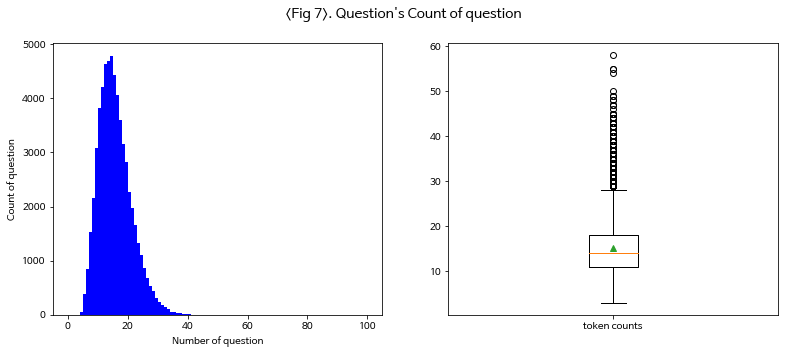

길이 최대:      58
길이 최소:       3
길이 평균:      15.25
길이 표준편차:    5.50
 25/100분위:    11.00
 50/100분위:    14.00
 75/100분위:    18.00
 IQR:           7.00
 MAX/100분위:   28.50


In [14]:
train_question_counts = [len(question) for question in questions]

show_sentence_length(train_question_counts, [0, 100], "<Fig 7>. Question's Count of question")

<br>

#### 지문(Context) 데이터 분석
***
+ 문장의 길이는 최대 4,816개의 토큰, 75%는 248개의 토큰으로 이루어져 있습니다.
***

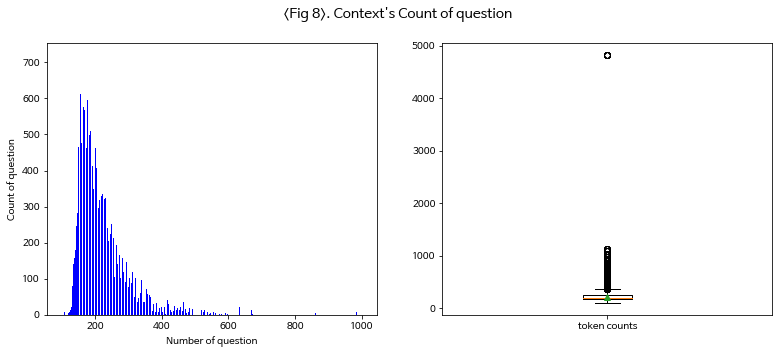

길이 최대:    4816
길이 최소:     108
길이 평균:     222.84
길이 표준편차:   97.68
 25/100분위:   169.00
 50/100분위:   199.00
 75/100분위:   248.00
 IQR:          79.00
 MAX/100분위:  366.50


In [15]:
train_context_counts = [len(context) for context in contexts]

show_sentence_length(train_context_counts, [100, 1000], "<Fig 8>. Context's Count of question")

<br>

#### 정답(Answer) 데이터 분석
***
+ 문장의 길이는 최대 1,124개의 토큰, 75%는 134개의 토큰으로 이루어져 있습니다.
***

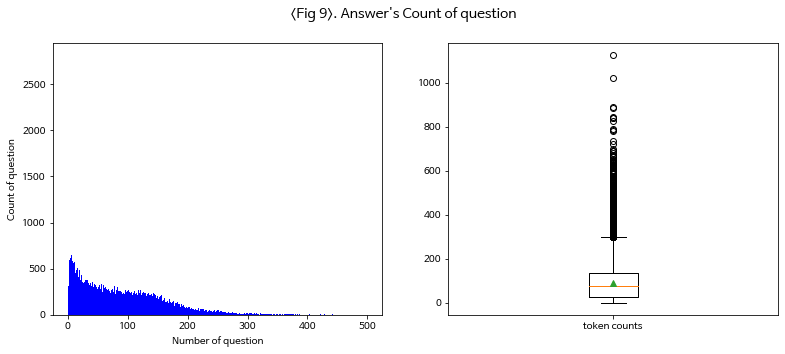

길이 최대:    1124
길이 최소:       0
길이 평균:      89.01
길이 표준편차:   78.21
 25/100분위:    25.00
 50/100분위:    74.00
 75/100분위:   134.00
 IQR:         109.00
 MAX/100분위:  297.50


In [16]:
train_answer_starts = token_starts

show_sentence_length(train_answer_starts, [0, 500], "<Fig 9>. Answer's Count of question")

<br>

## 5. 데이터 전처리
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 데이터를 모델에 입력할 수 있도록 전처리 과정을 수행합니다. 전처리 과정은 크게 '자연어를 정수로 변환하는 과정', '지문과 질문 문장을 연결하는 과정', '데이터셋 생성' 순으로 이루어집니다.
</span>

***

#### 데이터 전처리 함수 생성
***
+ 데이터를 설정한 길이에 맞추어 자릅니다.
 
 
+ 자연어 문장을 정수로 변환하여 줍니다.
 
 
+ BERT에 입력하기 위해 지문과 질문 문장을 연결하여 줍니다.
***

In [17]:
train_json = os.path.join(data_dir, "korquad_train.json")
dev_json = os.path.join(data_dir, "korquad_dev.json")

class Config(dict):
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

args = Config({
    'max_seq_length': 384,
    'max_query_length': 64,
})


# 생성한 데이터셋 파일을 메모리에 로딩하는 함수
def load_data(args, filename):
    inputs, segments, labels_start, labels_end = [], [], [], []

    n_discard = 0
    with open(filename, "r") as f:
        for i, line in enumerate(tqdm(f, desc=f"Loading ...")):
            data = json.loads(line)
            token_start = data.get("token_start")
            token_end = data.get("token_end")
            question = data["question"][:args.max_query_length]
            context = data["context"]
            answer_tokens = " ".join(context[token_start:token_end + 1])
            context_len = args.max_seq_length - len(question) - 3

            if token_end >= context_len:
                # 최대 길이내에 token이 들어가지 않은 경우 처리하지 않음
                n_discard += 1
                continue
            context = context[:context_len]
            assert len(question) + len(context) <= args.max_seq_length - 3

            tokens = ['[CLS]'] + question + ['[SEP]'] + context + ['[SEP]']
            ids = [vocab.piece_to_id(token) for token in tokens]
            ids += [0] * (args.max_seq_length - len(ids))
            inputs.append(ids)
            segs = [0] * (len(question) + 2) + [1] * (len(context) + 1)
            segs += [0] * (args.max_seq_length - len(segs))
            segments.append(segs)
            token_start += (len(question) + 2)
            labels_start.append(token_start)
            token_end += (len(question) + 2)
            labels_end.append(token_end)

    return (np.array(inputs), np.array(segments)), (np.array(labels_start), np.array(labels_end))

<br>

#### 데이터 전처리 실시
***
+ 앞서 정의한 함수를 이용하여 학습 데이터와 검증 데이터를 전처리 하여 줍니다.
***

In [18]:
# train data load
train_inputs, train_labels = load_data(args, train_json)
print(f"train_inputs: {train_inputs[0].shape}")
print(f"train_labels: {train_labels[0].shape}")

# dev data load
dev_inputs, dev_labels = load_data(args, dev_json)
print(f"dev_inputs: {dev_inputs[0].shape}")
print(f"dev_labels: {dev_labels[0].shape}")

Loading ...: 0it [00:00, ?it/s]

train_inputs: (59977, 384)
train_labels: (59977,)


Loading ...: 0it [00:00, ?it/s]

dev_inputs: (5696, 384)
dev_labels: (5696,)


<br>

#### 데이터셋 생성
***
+ 최종적으로 데이터를 데이터셋으로 생성합니다.
***

In [19]:
bert_batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs, train_labels)).shuffle(10000).batch(bert_batch_size)
dev_dataset = tf.data.Dataset.from_tensor_slices((dev_inputs, dev_labels)).batch(bert_batch_size)

<br>

#### 데이터셋 샘플 출력하기
***
+ INPUT SAMPLE은 질문과 지문이 &lt;CLS> + 질문 + &lt;SEP> + 지문 + &lt;SEP> 형태로 되어있으며, 정수로 변환된 것을 확인할 수 있습니다.


+ SEGMENT SAMPLE은 질문과 지문을 구분하여 줍니다.


+ START INDEX와 END INDEX를 통해 정답 문장 혹은 단어의 위치를 확인할 수 있습니다.
***

In [20]:
input_sample = train_inputs[0][0].tolist()
segment_sample = train_inputs[1][0]


print("<INPUT SAMPLE>\n", input_sample, end="\n\n")
print("<SEGMENT SAMPLE>\n", segment_sample, end="\n\n")

print(
    "<START INDEX>:", train_labels[0][0], "\n",
    "<END INDEX>:", train_labels[1][0]
)

<INPUT SAMPLE>
 [5, 15798, 10, 28935, 9, 11, 29566, 20, 14604, 20424, 3904, 70, 11, 4648, 10, 19, 1910, 4, 22070, 15, 15798, 10, 28935, 9, 11, 29566, 16, 626, 14604, 38, 14028, 11773, 13829, 384, 8376, 3021, 1239, 6874, 16, 1687, 5958, 2694, 5061, 7, 30, 1613, 15798, 10, 28065, 75, 4415, 1816, 4978, 27, 347, 145, 107, 2703, 263, 11, 1, 18, 5853, 99, 9677, 24, 11969, 13, 7595, 437, 1019, 5907, 257, 3794, 1972, 20, 11278, 11, 29566, 9, 612, 12631, 13214, 1732, 76, 7, 110, 8802, 17581, 354, 9648, 2060, 21, 1682, 22110, 18164, 17, 21076, 14980, 9, 6874, 81, 11325, 4239, 3597, 1010, 1035, 17670, 8, 2447, 1306, 35, 443, 11, 29566, 9, 315, 12729, 14457, 30, 7938, 3742, 10766, 634, 9971, 17590, 19424, 10, 285, 4080, 61, 17573, 483, 7, 7588, 9, 473, 338, 147, 1924, 9, 11016, 136, 1034, 13, 11672, 40, 3436, 5217, 7898, 11684, 57, 830, 9, 19, 3319, 86, 220, 464, 14980, 9, 20515, 412, 991, 684, 1924, 9, 634, 920, 144, 430, 34, 25, 7, 4210, 6874, 2150, 16, 22070, 298, 1159, 75, 1098, 8802, 7490, 80

<br>

#### 데이터셋 샘플 출력하기2
***
+ 정수로 변환된 INPUT SAMPLE을 확인하기 위해 다시 자연어로 변환하여 출력합니다.


+ INPUT SAMPLE은 질문과 지문이 &lt;CLS> + 질문 + &lt;SEP> + 지문 + &lt;SEP> 형태로 되어있으며, 정수로 변환된 것을 확인할 수 있습니다.
***

In [21]:
print("<INT INPUT SAMPLE>\n", input_sample, end="\n\n")
print("↓" * 50)
print("\n<STR INPUT SAMPLE>\n", vocab.DecodeIds(input_sample))

<INT INPUT SAMPLE>
 [5, 15798, 10, 28935, 9, 11, 29566, 20, 14604, 20424, 3904, 70, 11, 4648, 10, 19, 1910, 4, 22070, 15, 15798, 10, 28935, 9, 11, 29566, 16, 626, 14604, 38, 14028, 11773, 13829, 384, 8376, 3021, 1239, 6874, 16, 1687, 5958, 2694, 5061, 7, 30, 1613, 15798, 10, 28065, 75, 4415, 1816, 4978, 27, 347, 145, 107, 2703, 263, 11, 1, 18, 5853, 99, 9677, 24, 11969, 13, 7595, 437, 1019, 5907, 257, 3794, 1972, 20, 11278, 11, 29566, 9, 612, 12631, 13214, 1732, 76, 7, 110, 8802, 17581, 354, 9648, 2060, 21, 1682, 22110, 18164, 17, 21076, 14980, 9, 6874, 81, 11325, 4239, 3597, 1010, 1035, 17670, 8, 2447, 1306, 35, 443, 11, 29566, 9, 315, 12729, 14457, 30, 7938, 3742, 10766, 634, 9971, 17590, 19424, 10, 285, 4080, 61, 17573, 483, 7, 7588, 9, 473, 338, 147, 1924, 9, 11016, 136, 1034, 13, 11672, 40, 3436, 5217, 7898, 11684, 57, 830, 9, 19, 3319, 86, 220, 464, 14980, 9, 20515, 412, 991, 684, 1924, 9, 634, 920, 144, 430, 34, 25, 7, 4210, 6874, 2150, 16, 22070, 298, 1159, 75, 1098, 8802, 7490

<br>

## 5. 모델 생성 및 학습
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 사전학습이 이루어지지 않은 BERT와 사전학습이 이루어진 BERT의 KorQuA 문제 해결 성능을 비교하고자 합니다. 모델은 공통적으로 6개의 인코더 레이어를 쌓고 8개의 멀티 헤드를 사용합니다. 총 Epoch는 5회로 설정합니다.
</span>

***

#### 학습 함수 생성
***
+ 모델 학습을 위한 함수를 생성합니다.
***

In [23]:
#학습 데이터 Epoch============================================
def train_epoch(model, dataset, loss_fn, acc_fn, optimizer):
    metric_start_loss = tf.keras.metrics.Mean(name='start_loss')
    metric_end_loss = tf.keras.metrics.Mean(name='end_loss')
    metric_start_acc = tf.keras.metrics.Mean(name='start_acc')
    metric_end_acc = tf.keras.metrics.Mean(name='end_acc')

    p_bar = tqdm(dataset)
    for batch, ((enc_tokens, segments), (start_labels, end_labels)) in enumerate(p_bar):
        with tf.GradientTape() as tape:
            start_outputs, end_outputs = model(enc_tokens, segments)

            start_loss = loss_fn(start_labels, start_outputs)
            end_loss = loss_fn(end_labels, end_outputs)
            loss = start_loss + end_loss

            start_acc = acc_fn(start_labels, start_outputs)
            end_acc = acc_fn(end_labels, end_outputs)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        metric_start_loss(start_loss)
        metric_end_loss(end_loss)
        metric_start_acc(start_acc)
        metric_end_acc(end_acc)
        if batch % 10 == 9:
            p_bar.set_description(
                f'loss: {metric_start_loss.result():0.4f}, \
                {metric_end_loss.result():0.4f}, \
                acc: {metric_start_acc.result():0.4f}, \
                {metric_end_acc.result():0.4f}'
            )
    p_bar.close()

    return metric_start_loss.result(), metric_end_loss.result(), metric_start_acc.result(), metric_end_acc.result()
#End==========================================================


#검증 데이터 Epoch============================================
def eval_epoch(model, dataset, loss_fn, acc_fn):
    metric_start_loss = tf.keras.metrics.Mean(name='start_loss')
    metric_end_loss = tf.keras.metrics.Mean(name='end_loss')
    metric_start_acc = tf.keras.metrics.Mean(name='start_acc')
    metric_end_acc = tf.keras.metrics.Mean(name='end_acc')

    for batch, ((enc_tokens, segments), (start_labels, end_labels)) in enumerate(dataset):
        start_outputs, end_outputs = model(enc_tokens, segments)

        start_loss = loss_fn(start_labels, start_outputs)
        end_loss = loss_fn(end_labels, end_outputs)

        start_acc = acc_fn(start_labels, start_outputs)
        end_acc = acc_fn(end_labels, end_outputs)

        metric_start_loss(start_loss)
        metric_end_loss(end_loss)
        metric_start_acc(start_acc)
        metric_end_acc(end_acc)

    return metric_start_loss.result(), metric_end_loss.result(), metric_start_acc.result(), metric_end_acc.result()
#End==========================================================

<br>

### 5.1. 초기화된 BERT
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 사전학습이 이루어지지 않은 모델을 5회 학습하였습니다. 그 결과 학습 데이터 및 검증 데이터에 대한 손실 값이 증가하였습니다. 반대로 정확도는 하락하였습니다. 최종 결과는 검증 데이터에 대한 손실 값이 약 6.0이고 정확도는 약 0.003 입니다.
</span>

***

#### 모델 생성
***
+ BERT 모델을 생성 합니다.
***

In [24]:
config = Config({
    "d_model": 512, "n_head": 8, "d_head": 64,
    "dropout": 0.1, "d_ff": 1024, "layernorm_epsilon": 0.001,
    "n_layer": 6, "n_seq": 384, "n_vocab": 0, "i_pad": 0
})

config.n_vocab = len(vocab)
config.i_pad = vocab.pad_id()

model = BERT4KorQuAD(config)

<br>

#### 모델 학습
***
+ Epoch 5회로 설정하여 학습합니다.
***

In [31]:
loss_fn = tf.keras.losses.sparse_categorical_crossentropy
acc_fn = tf.keras.metrics.sparse_categorical_accuracy

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)

best_acc, patience = .0, 0

train_start_loss, train_end_loss, train_start_acc, train_end_acc = [], [], [], []
val_start_loss, val_end_loss, val_start_acc, val_end_acc = [], [], [], []


for epoch in range(5):
    t_start_loss, t_end_loss, t_start_acc, t_end_acc = train_epoch(model, train_dataset, loss_fn, acc_fn, optimizer)
    start_loss, end_loss, start_acc, end_acc = eval_epoch(model, dev_dataset, loss_fn, acc_fn)
    
    train_start_loss.append(t_start_loss)
    train_end_loss.append(t_end_loss)
    train_start_acc.append(t_start_acc)
    train_end_acc.append(t_end_acc)
    
    val_start_loss.append(start_loss)
    val_end_loss.append(end_loss)
    val_start_acc.append(start_acc)
    val_end_acc.append(end_acc)
    
    
    print(f'eval {epoch} >> loss: {start_loss:0.4f}, {end_loss:0.4f}, acc: {start_acc:0.4f}, {end_acc:0.4f}')
    acc = start_acc + end_acc
    if best_acc < acc:
        patience = 0
        best_acc = acc
        model.save_weights(os.path.join(data_dir, "korquad_bert_none_pretrain.hdf5"))
        print(f'save best model')
    else:
        patience += 1
    if 5 <= patience:
        print(f'early stopping')
        break

  0%|          | 0/1875 [00:00<?, ?it/s]

eval 0 >> loss: 3.6503, 4.2335, acc: 0.1334, 0.1122
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 1 >> loss: 5.9506, 5.9506, acc: 0.0042, 0.0042


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 2 >> loss: 5.9506, 5.9506, acc: 0.0100, 0.0075


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 3 >> loss: 5.9506, 5.9506, acc: 0.0033, 0.0033


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 4 >> loss: 5.9506, 5.9506, acc: 0.0025, 0.0039


<br>

#### 모델 결과 시각화
***
+ 모델의 학습 결과를 시각화 합니다.
***

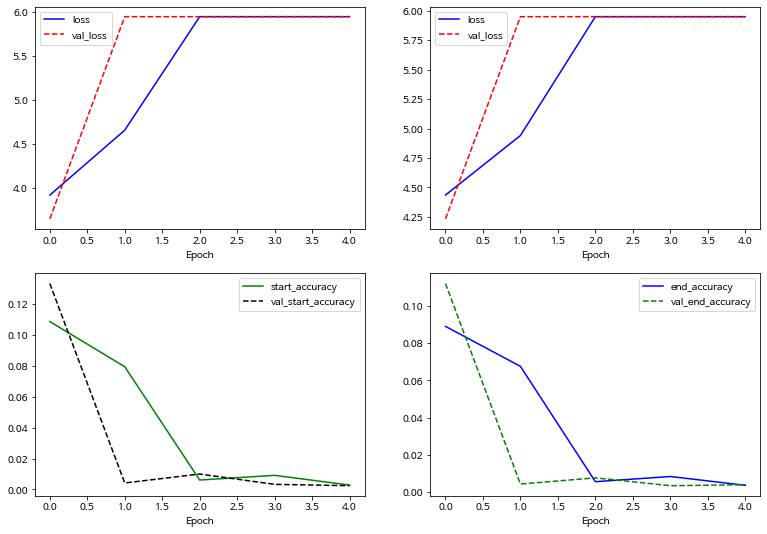

In [32]:
plt.figure(figsize=(13, 9))

plt.subplot(2, 2, 1)
plt.plot(train_start_loss, 'b-', label='start_loss')
plt.plot(val_start_loss, 'r--', label='val_start_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(train_end_loss, 'b-', label='end_loss')
plt.plot(val_end_loss, 'r--', label='val_end_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(train_start_acc, 'g-', label='start_accuracy')
plt.plot(val_start_acc, 'k--', label='val_start_accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(train_end_acc, 'b-', label='end_accuracy')
plt.plot(val_end_acc, 'g--', label='val_end_accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.show()

<br>

### 5.2. 사전학습된 BERT
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 사전학습이 이루어진 모델을 5회 학습하였습니다. 그 결과 학습 데이터 및 검증 데이터에 대한 손실 값은 감소하고 정확도는 상승하였습니다. 최종 결과는 검증 데이터에 대한 손실 값이 약 2.3이고 정확도는 약 0.5 입니다. 사전학습이 이루어지지 않은 모델에 비해 좀 더 좋은 성능을 보여줍니다. 또한, 검증 데이터 10개를 모델에 입력하여 모델이 하는 예측을 출력하였습니다. 여러 문제에 대해 올바른 예측을 하는 것을 확인할 수 있었습니다.
</span>

***

#### 사전 학습된 모델 불러오기
***
+ Pretrained된 모델을 불러옵니다.
***

In [25]:
checkpoint_file = os.path.join(model_dir, 'bert_pretrain_32000.hdf5')

model = BERT4KorQuAD(config)

if os.path.exists(checkpoint_file):
    #  pretrained model 을 로드하기 위해 먼저 모델이 생성되어 있어야 한다.
    enc_tokens = np.random.randint(0, len(vocab), (4, 10))
    segments = np.random.randint(0, 2, (4, 10))
    model(enc_tokens, segments)
    
    # checkpoint 파일로부터 필요한 layer를 불러온다. 
    model.load_weights(os.path.join(model_dir, "bert_pretrain_32000.hdf5"), by_name=True)

    model.summary()

Model: "BERT4KorQuAD"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (BERT)                  multiple                  29202944  
_________________________________________________________________
dense_73 (Dense)             multiple                  1026      
Total params: 29,203,970
Trainable params: 29,203,970
Non-trainable params: 0
_________________________________________________________________


<br>

#### 모델 학습
***
+ Epoch 5회로 설정하여 학습합니다.
***

In [26]:
loss_fn = tf.keras.losses.sparse_categorical_crossentropy
acc_fn = tf.keras.metrics.sparse_categorical_accuracy

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)

best_acc, patience = .0, 0

train_start_loss, train_end_loss, train_start_acc, train_end_acc = [], [], [], []
val_start_loss, val_end_loss, val_start_acc, val_end_acc = [], [], [], []


for epoch in range(5):
    t_start_loss, t_end_loss, t_start_acc, t_end_acc = train_epoch(model, train_dataset, loss_fn, acc_fn, optimizer)
    start_loss, end_loss, start_acc, end_acc = eval_epoch(model, dev_dataset, loss_fn, acc_fn)
    
    train_start_loss.append(t_start_loss)
    train_end_loss.append(t_end_loss)
    train_start_acc.append(t_start_acc)
    train_end_acc.append(t_end_acc)
    
    val_start_loss.append(start_loss)
    val_end_loss.append(end_loss)
    val_start_acc.append(start_acc)
    val_end_acc.append(end_acc)
    
    
    print(f'eval {epoch} >> loss: {start_loss:0.4f}, {end_loss:0.4f}, acc: {start_acc:0.4f}, {end_acc:0.4f}')
    acc = start_acc + end_acc
    if best_acc < acc:
        patience = 0
        best_acc = acc
        model.save_weights(os.path.join(data_dir, "korquad_bert_none_pretrain.hdf5"))
        print(f'save best model')
    else:
        patience += 1
    if 5 <= patience:
        print(f'early stopping')
        break

  0%|          | 0/1875 [00:00<?, ?it/s]

eval 0 >> loss: 1.7783, 2.0568, acc: 0.5425, 0.5025
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 1 >> loss: 1.6813, 1.9608, acc: 0.5572, 0.5144
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 2 >> loss: 1.7531, 1.8987, acc: 0.5874, 0.5493
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 3 >> loss: 1.9568, 2.4227, acc: 0.5637, 0.5054


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 4 >> loss: 2.3145, 2.3769, acc: 0.5555, 0.5184


<br>

#### 모델 결과 시각화
***
+ 모델의 학습 결과를 시각화 합니다.
***

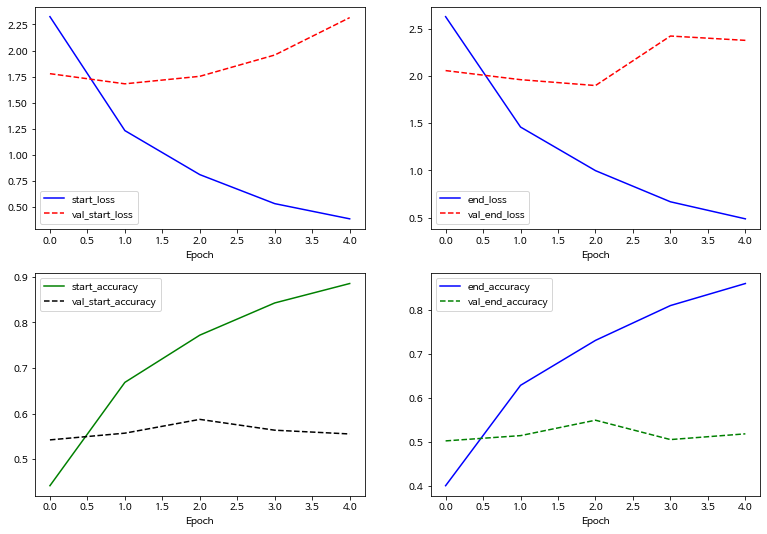

In [28]:
plt.figure(figsize=(13, 9))

plt.subplot(2, 2, 1)
plt.plot(train_start_loss, 'b-', label='start_loss')
plt.plot(val_start_loss, 'r--', label='val_start_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(train_end_loss, 'b-', label='end_loss')
plt.plot(val_end_loss, 'r--', label='val_end_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(train_start_acc, 'g-', label='start_accuracy')
plt.plot(val_start_acc, 'k--', label='val_start_accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(train_end_acc, 'b-', label='end_accuracy')
plt.plot(val_end_acc, 'g--', label='val_end_accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.show()

<br>

#### 검증 데이터 테스트 하기
***
+ 사전 학습된 모델에 검증 데이터를 입력하여 테스트 합니다.
***

In [31]:
def do_predict(model, question, context):
    q_tokens = vocab.encode_as_pieces(question)[:args.max_query_length]
    c_tokens = vocab.encode_as_pieces(context)[:args.max_seq_length - len(q_tokens) - 3]
    tokens = ['[CLS]'] + q_tokens + ['[SEP]'] + c_tokens + ['[SEP]']
    token_ids = [vocab.piece_to_id(token) for token in tokens]
    segments = [0] * (len(q_tokens) + 2) + [1] * (len(c_tokens) + 1)

    y_start, y_end = model(np.array([token_ids]), np.array([segments]))
    # print(y_start, y_end)
    y_start_idx = K.argmax(y_start, axis=-1)[0].numpy()
    y_end_idx = K.argmax(y_end, axis=-1)[0].numpy()
    answer_tokens = tokens[y_start_idx:y_end_idx + 1]

    return vocab.decode_pieces(answer_tokens)



dev_json = os.path.join(data_dir, "korquad_dev.json")

with open(dev_json) as f:
    for i, line in enumerate(f):
        data = json.loads(line)
        question = vocab.decode_pieces(data['question'])
        context = vocab.decode_pieces(data['context'])
        answer = data['answer']
        answer_predict = do_predict(model, question, context)
        if answer in answer_predict:
            print(i)
            print("질문 : ", question)
            print("지문 : ", context)
            print("정답 : ", answer)
            print("예측 : ", answer_predict, "\n")
        if 10 < i:
            break

0
질문 :  임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배 된 날은?
지문 :  1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임종석을 발견, 검거해 구속을 집행했다. 임종석은 청량리경찰서에서 약 1시간 동안 조사를 받은 뒤 오전 9시 50분 경 서울 장안동의 서울지방경찰청 공안분실로 인계되었다.
정답 :  1989년 2월 15일
예측 :  1989년 2월 15일 

1
질문 :  1989년 6월 30일 평양축전에 대표로 파견 된 인물은?
지문 :  1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임

<br>

## 6. 결론
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; BERT의 사전학습된 모델과 사전학습 되지 않은 모델의 성능을 비교하기 위해 KorQuA 문제를 이용하였습니다. 두 모델의 하이퍼파라미터는 동일하게 6개의 인코더 레이어와 8개의 멀티 헤드를 사용하였으며, 학습 횟수는 5회로 설정하였습니다. 학습 결과, 사전학습되지 않은 모델은 손실 값이 오히려 증가하는 추세를 보였습니다. 반대로 정확도는 하락하는 추세를 보였습니다. 최종 정확도는 약 0.003에 해당합니다. 사전학습된 모델의 경우, 손실 값이 하락하고 정확도는 상승하는 형태를 보였습니다. 최종 정확도는 약 0.5에 해당합니다. 또한, 검증 데이터 10개를 사전학습된 모델에 입력하여 모델의 예측을 확인하였습니다. 그 결과, 여러 문제에 대해 올바르게 예측함을 확인 할 수 있었습니다.
</span>

***

#### 형상관리 기록
***
+ v1_1: 실습 예제 진행


+ v2_1: 제출 예제 진행


+ v3_1: 내용 작성


+ v4_1: 사전학습된 모델 학습
***